File Changed
- base version: exp010
- ViT with dino: https://www.guruguru.science/competitions/17/discussions/2208c2a7-1bfd-4177-9334-b9c7faa0cd7f/
    - arch: tiny -> small
    - epoch: 100 -> 300
- training epochs: 30 -> 100
    - with early stopping rounds: 10 times in a row

In [1]:
# !git clone https://github.com/facebookresearch/dino.git > /dev/null

In [2]:
# !cd ../input \
#     && mkdir -p data/train/0 \
#     && rm -r data \
#     && mkdir -p data/train/0 \
#     && cp photos/*.jpg data/train/0/

In [5]:
# !cd ./dino \
#     && python -m torch.distributed.launch \
#     --nproc_per_node=1 \
#     main_dino.py \
#     --arch 'vit_small' \
#     --data_path='../../input/data' \
#     --output_dir='../../output/model/dino/exp11' \
#     --epochs=300 \
#     --batch_size_per_gpu=32

Using cache found in /root/.cache/torch/hub/facebookresearch_xcit_master
| distributed init (rank 0): env://
git:
  sha: ba9edd18db78a99193005ef991e04d63984b25a8, status: clean, branch: main

arch: vit_small
batch_size_per_gpu: 32
clip_grad: 3.0
data_path: ../../input/data
dist_url: env://
drop_path_rate: 0.1
epochs: 300
freeze_last_layer: 1
global_crops_scale: (0.4, 1.0)
gpu: 0
local_crops_number: 8
local_crops_scale: (0.05, 0.4)
local_rank: 0
lr: 0.0005
min_lr: 1e-06
momentum_teacher: 0.996
norm_last_layer: True
num_workers: 10
optimizer: adamw
out_dim: 65536
output_dir: ../../output/model/dino/exp11
patch_size: 16
rank: 0
saveckp_freq: 20
seed: 0
teacher_temp: 0.04
use_bn_in_head: False
use_fp16: True
warmup_epochs: 10
warmup_teacher_temp: 0.04
warmup_teacher_temp_epochs: 0
weight_decay: 0.04
weight_decay_end: 0.4
world_size: 1
/venv/lib/python3.8/site-packages/torchvision/transforms/transforms.py:803: UserWarning: Argument interpolation should be of type InterpolationMode instead o

In [1]:
import os
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


sns.set_style("whitegrid")

In [2]:
from dataclasses import dataclass, field
from glob import glob

import torch


@dataclass
class InputPath:
    _prefix: str = "../input"
    train: str = f"{_prefix}/train.csv"
    materials: str = f"{_prefix}/materials.csv"
    techniques: str = f"{_prefix}/techniques.csv"
    test: str = f"{_prefix}/test.csv"
    sub: str = f"{_prefix}/atmaCup#11_sample_submission.csv"
    photos_prefix: str = f"{_prefix}/photos"
    photos: List[str] = field(default_factory=lambda: glob(f"../input/photos/*.jpg"))
        
        
@dataclass
class OutputPath:
    _prefix: str = "../output/"
    model: str = f"{_prefix}/model"
    submission: str = f"{_prefix}/submission"

        
@dataclass
class Basic:
    run_name: str = "exp011"
    is_debug: bool = False
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
        
        
@dataclass
class Kfold:
    number: int = 5
    method: str = "skf"
    shuffle: bool = True
    columns: List[str] = field(default_factory=lambda: ["target"])
        
        
@dataclass
class Adam:
    name: str = "Adam"
    lr: float = 1e-4
    weight_decay: float = 0
    amsgrad: bool = False
        
        
@dataclass
class ReduceLROnPlateau:
    name: str = "ReduceLROnPlateau"
    mode: str = "min"
    factor: float = 0.1
    patience: int = 5
    verbose: bool = True
    eps: float = 1e-8

        
@dataclass
class Params:
    batch_size: int = 256
#     ssl_batch_size: int =128
    test_batch_size: int = 1024
    epochs: int = 3 if Basic.is_debug else 100
    image_size: int = 224
#     max_grad_norm: int = 1000
    num_workers: int = 0
#     print_freq: int = 10000
    target_size: int = 1
    # Union[Adam]
    optimizer: Adam = Adam()
    # Union[CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau]
    scheduler: ReduceLROnPlateau = ReduceLROnPlateau()
    pretrained: bool = False
    num_aug: int = 5
    num_tta: int = 10
    early_stopping_rounds: int = 10


@dataclass
class DinoParams:
    arch: str = "vit_small"
    embed_dim: int = 384
    patch_size: int = 16
    checkpoint: str = "../output/model/dino/exp11/checkpoint0280.pth"
        

@dataclass
class ModelConfig:
    basic: Basic = Basic()
    kfold: Kfold = Kfold()
    params: Params = Params()
    dino_params: DinoParams = DinoParams()

In [3]:
# for x in os.listdir(OutputPath.model) if x.startswith("exp???_"):
#     os.remove(f"{OutputPath.model}/{x}")

In [4]:
past_sessions = [x.split("_")[0] for x in os.listdir(OutputPath.model) if x.endswith("_0.pth")]
assert Basic.run_name not in past_sessions

In [5]:
import math
import os
import random
import time

import joblib
import numpy as np
import torch
from sklearn import metrics


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class Jbl:
    @staticmethod
    def load(filepath: str) -> Any:
        return joblib.load(filepath)

    @staticmethod
    def save(obj_: Any, filepath: str) -> None:
        joblib.dump(obj_, filepath, compress=3)


def RMSE(y: np.array, p: np.array) -> float:
    return metrics.mean_squared_error(y, p) ** 0.5


def fix_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    
def time_since(since: time.time, percent: float) -> str:
    def as_minutes(s):
        m = math.floor(s / 60)
        s -= m * 60
        return "%dm %ds" % (m, s)

    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (as_minutes(s), as_minutes(rs))

In [6]:
from PIL import Image


def to_img_path(photo_dir: str, object_id: str) -> str:
    return os.path.join(photo_dir, f'{object_id}.jpg')

def read_image(object_id: str):
    return Image.open(to_img_path(object_id))

In [7]:
import pandas as pd


def load_csv(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [8]:
from sklearn.model_selection import (
    GroupKFold,
    KFold,
    StratifiedKFold,
    TimeSeriesSplit,
)


def generate_kf(cfg: ModelConfig) -> Generator:
    if cfg.kfold.method == "kf":
        kf = KFold(
            n_splits=cfg.kfold.number,
            shuffle=cfg.kfold.shuffle,
            random_state=cfg.basic.seed,
        )
    elif cfg.kfold.method == "skf":
        kf = StratifiedKFold(
            n_splits=cfg.kfold.number,
            shuffle=cfg.kfold.shuffle,
            random_state=cfg.basic.seed,
        )
    elif cfg.kfold.method == "gkf":
        kf = GroupKFold(n_splits=cfg.kfold.number)
    elif cfg.kfold.method == "sgkf":
        kf = StratifiedGroupKFold(
            n_splits=cfg.kfold.number, random_state=cfg.basic.seed
        )
    elif cfg.kfold.method == "tskf":
        kf = TimeSeriesSplit(n_splits=cfg.kfold.number)
    else:
        raise ValueError(f"{cfg.kfold.method} is not supported")
    return kf

In [9]:
import pandas as pd
from PIL import Image
from torch.utils import data
from torchvision import transforms as T


IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]


class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    label_key = "target"

    def __init__(self, meta_df: pd.DataFrame, is_train: bool = True) -> None:
        self.is_train = is_train
        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")
        
        size = (ModelConfig.params.image_size, ModelConfig.params.image_size)
        additional_items = (
            [T.Resize(size)]
            if not is_train
            else [
                T.RandomGrayscale(p=0.2),
                T.RandomHorizontalFlip(),
                T.ColorJitter(
                    brightness=0.3,
                    contrast=0.5,
                    saturation=[0.8, 1.3],
                    hue=[-0.05, 0.05],
                ),
                T.RandomResizedCrop(size),
            ]
        )
        self.transformer = T.Compose(
            [*additional_items, T.ToTensor(), T.Normalize(mean=IMG_MEAN, std=IMG_STD)]
        )
        
        self._validate_meta_df(meta_df)

    def __getitem__(self, index) -> Dict[str, Any]:
        data = self.index_to_data[index]
        obj_path, label = data.get(self.object_path_key), data.get(self.label_key, -1)
        img = self.transformer(Image.open(obj_path))
        return {"image": img, "label": label}

    def __len__(self) -> int:
        return len(self.meta_df)
    
    def _validate_meta_df(self, meta_df: pd.DataFrame) -> None:
        for k in self.meta_keys:
            if k not in meta_df:
                raise ValueError(f"meta df must have {k}")
                
    @property
    def meta_keys(self) -> List[str]:
        retval = [self.object_path_key]
        if self.is_train:
            retval += [self.label_key]
        return retval

In [10]:
import sys

sys.path.append("dino")

In [11]:
import os
import sys

import torch
from torch import nn

import dino.vision_transformer as vits


class AtmaModel(nn.Module):
    def __init__(
        self,
        backbone,
        in_features: int=384,
        hidden_dim: int=384,
        out_dim: int=1
    ):
        super(AtmaModel, self).__init__()
        self.backbone = backbone
        self.l1 = nn.Sequential(
                nn.Linear(in_features, hidden_dim),
                nn.ReLU(inplace=True),
            )
        self.l2 = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(inplace=True),
            )
        self.l3 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = x.view(x.size(0))
        return x


def build_model(model_config: ModelConfig):
    # https://github.com/bilzard/atmacup11.py/blob/main/model.py
    model = vits.__dict__[model_config.dino_params.arch](patch_size=model_config.dino_params.patch_size, num_classes=0)
    model.to(model_config.basic.device)
    
    state_dict = torch.load(model_config.dino_params.checkpoint, map_location=model_config.basic.device)
    state_dict = state_dict['teacher']
    
    # remove `module.` prefix
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    msg = model.load_state_dict(state_dict, strict=False)
    print('Pretrained weights found at {} and loaded with msg: {}'.format(model_config.dino_params.checkpoint, msg))

    a_model = AtmaModel(model, in_features=model_config.dino_params.embed_dim, hidden_dim=model_config.dino_params.embed_dim).to(model_config.basic.device)
    return a_model


def freeze_backbone_params(model):
    for param in model.parameters():
        param.requires_grad = True
    for param in model.backbone.parameters():
        param.requires_grad = False

In [12]:
import datetime
import time
from collections import OrderedDict
from logging import Logger
from typing import Dict, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm


class BaseRunner:
    def __init__(self, cfg: ModelConfig):
        self.cfg = cfg
        self.params = cfg.params

    def _get_scheduler(
        self, optimizer: Union[optim.Adam]
    ) -> Union[
        lr_scheduler.ReduceLROnPlateau,
    ]:
        if self.params.scheduler.name == "ReduceLROnPlateau":
            scheduler = lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode=self.params.scheduler.mode,
                factor=self.params.scheduler.factor,
                patience=self.params.scheduler.patience,
                verbose=self.params.scheduler.verbose,
                eps=self.params.scheduler.eps,
            )
        else:
            raise ValueError(f"{self.params.scheduler.name} is not supported")
        return scheduler

    def _step_scheduler(
        self,
        scheduler: Union[
            lr_scheduler.ReduceLROnPlateau,
        ],
        avg_val_loss,
    ) -> Union[
        lr_scheduler.ReduceLROnPlateau,
    ]:
        if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        else:
            raise ValueError(f"{self.params.shceduler.name} is not supported")
        return scheduler

    def _evaluate(self, y_true: np.array, y_pred: np.array):
        score = RMSE(y_true, y_pred)
        print(f"Score: {score:<.5f}")


class TrainRunner(BaseRunner):
    def _train_batch(self, train_loader, model, criterion, optimizer, scheduler, epoch):
        losses = AverageMeter()
        model.train()
        for _ in range(self.cfg.params.num_aug):
            for step, image_label_dict in enumerate(train_loader):
                images = image_label_dict.get("image").to(self.cfg.basic.device)
                labels = image_label_dict.get("label").to(self.cfg.basic.device)
                batch_size = labels.size(0)

                y_preds = model(images)
                loss = criterion(y_preds.squeeze(), labels.float())
                losses.update(loss.item(), batch_size)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return losses.avg

    def _valid_batch(self, valid_loader, model, criterion):
        losses = AverageMeter()
        model.eval()
        preds = []
        for _, image_label_dict in enumerate(valid_loader):
            images = image_label_dict.get("image").to(self.cfg.basic.device)
            labels = image_label_dict.get("label").to(self.cfg.basic.device)
            batch_size = labels.size(0)

            with torch.no_grad():
                y_preds = model(images)
            loss = criterion(y_preds.squeeze(), labels.float())
            losses.update(loss.item(), batch_size)
            preds.append(y_preds.to("cpu").numpy())
        predictions = np.concatenate(preds).reshape(-1, 1)
        return losses.avg, predictions

    def _train(self, train: pd.DataFrame, n_fold: int) -> pd.DataFrame:
        print(f"fold: {n_fold}")
        
        is_tta_mode = self.params.num_tta > 0
        num_times_tta = 1 if not is_tta_mode else self.params.num_tta

        trn_idx = train[train["fold"] != n_fold].index
        val_idx = train[train["fold"] == n_fold].index
        train_folds = train.loc[trn_idx].reset_index(drop=True)
        valid_folds = train.loc[val_idx].reset_index(drop=True)
        train_dataset = AtmaDataset(
            train_folds,
            is_train=True,
#             transform=get_transforms(self.params, data="train"),
        )
        valid_dataset = AtmaDataset(
            valid_folds,
            is_train=is_tta_mode,
#             transform=get_transforms(self.params, data="valid"),
        )
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.params.batch_size,
            shuffle=True,
            num_workers=self.params.num_workers,
            pin_memory=True,
            drop_last=True,
        )
        valid_loader = DataLoader(
            valid_dataset,
            batch_size=self.params.batch_size,
            shuffle=False,
            num_workers=self.params.num_workers,
            pin_memory=True,
            drop_last=False,
        )

        model = build_model(model_config=self.cfg)
        model.to(self.cfg.basic.device)
        freeze_backbone_params(model)  # linear layer 以外を freeze
        optimizer = optim.Adam(
            model.parameters(),
            lr=self.params.optimizer.lr,
            weight_decay=self.params.optimizer.weight_decay,
            amsgrad=self.params.optimizer.amsgrad,
        )
        scheduler = self._get_scheduler(optimizer)
        criterion = nn.MSELoss()
        
        best_model = None
        best_score = np.inf
        scores: List[float] = []
        num_not_improved = 0
        for epoch in range(self.params.epochs):
            start_time = time.time()

            avg_loss = self._train_batch(
                train_loader, model, criterion, optimizer, scheduler, epoch
            )
            avg_val_loss_list: List[float] = []
            preds_list: List[np.array] = []
            for _ in range(num_times_tta):
                avg_val_loss, preds = self._valid_batch(valid_loader, model, criterion)
                avg_val_loss_list.append(avg_val_loss)
                preds_list.append(preds)
            avg_val_loss = np.mean(avg_val_loss_list)
            preds = np.concatenate(preds_list, axis=1).mean(axis=1)
            valid_labels = valid_folds["target"].values
            scheduler = self._step_scheduler(scheduler, avg_val_loss)
            score = RMSE(valid_labels, preds)

            scores.append(score)
            elapsed = time.time() - start_time
            print(
                f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
            )
            print(f"Epoch {epoch+1} - RMSE: {score}")
            if best_score > score:
                best_model = model
                best_score = score
                num_not_improved = 0
            else:
                num_not_improved += 1
            print(
                f"Epoch {epoch+1} - Best Score: {best_score:.4f}"
            )
            if self.params.early_stopping_rounds > 0 and self.params.early_stopping_rounds == num_not_improved:
                print(f"Early stopping break: not improved {num_not_improved} times in a row")
                break

        torch.save(
            {
                "model": best_model.state_dict(), 
                "preds": preds, 
                "best_score": best_score, 
                "scores": scores
            },
            f"{OutputPath.model}/{self.cfg.basic.run_name}_{n_fold}.pth",
        )
        check_point: Dict[str, Union[OrderedDict, torch.Tensor]] = torch.load(
            f"{OutputPath.model}/{self.cfg.basic.run_name}_{n_fold}.pth"
        )
        valid_folds["preds"] = check_point["preds"]
        return valid_folds

    def run_cv(self, train: pd.DataFrame) -> None:
        print(f"debug mode: {self.cfg.basic.is_debug}")
        print(f"start time: {datetime.datetime.now()}")
        oof_df = pd.DataFrame()
        for n_fold in range(self.cfg.kfold.number):
            _oof_df = self._train(train, n_fold)
            print(f"========== fold: {n_fold} result ==========")
            self._evaluate(_oof_df["target"], _oof_df["preds"])
            oof_df = pd.concat([oof_df, _oof_df])
        print("========== CV ==========")
        self._evaluate(oof_df["target"], oof_df["preds"])
        Jbl.save(oof_df, f"{OutputPath.model}/oof_df_{self.cfg.basic.run_name}.jbl")

In [22]:
class InferenceRunner(BaseRunner):
    def _test_batch(self, test_loader, model):
        model.eval()
        preds = []
        for step, image_label_dict in enumerate(test_loader):
            images = image_label_dict.get("image").to(self.cfg.basic.device)
            with torch.no_grad():
                y_preds = model(images)
            preds.append(y_preds.to("cpu").numpy())
        predictions = np.concatenate(preds).reshape(-1, 1)
        return predictions

    def _test(self, test: pd.DataFrame, n_fold: int):
        print(f"fold: {n_fold}")
        test_dataset = AtmaDataset(
            test,
            is_train=False,
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=self.params.test_batch_size,
            shuffle=False,
            num_workers=self.params.num_workers,
            pin_memory=True,
            drop_last=False,
        )

        model = build_model(model_config=self.cfg)
        model_state = torch.load(f"{OutputPath.model}/{self.cfg.basic.run_name}_{n_fold}.pth")["model"]
        model.load_state_dict(model_state)
        model.to(self.cfg.basic.device)
        preds = self._test_batch(test_loader, model)
        return preds
    
    def _submit(self, preds: np.array) -> None:
        df_sub = load_csv(input_path.sub)
        df_sub = df_sub.assign(target=np.clip(preds, 0, 3))
        path = f"{OutputPath.submission}/submission_{self.cfg.basic.run_name}.csv"
        df_sub.to_csv(path, index=False)
        print("submission.csv created")

    def run_cv(self, test: pd.DataFrame) -> None:
        oof_df = pd.DataFrame()
        preds: List[np.array] = []
        for n_fold in range(self.cfg.kfold.number):
            preds_fold = self._test(test, n_fold)
            preds.append(preds_fold)
        Jbl.save(preds, f"{OutputPath.model}/preds_test_{self.cfg.basic.run_name}.jbl")
        
        preds_mean = np.concatenate(preds, axis=1).mean(axis=1)
        self._submit(preds_mean)

In [14]:
fix_seed()
input_path = InputPath()
model_config = ModelConfig()

In [15]:
train = load_csv(input_path.train)
train = train.assign(object_path = train["object_id"].apply(lambda x: to_img_path(input_path.photos_prefix, x)))
print(train.shape)
display(train.head(3))

(3937, 5)


,object_id,sorting_date,art_series_id,target,object_path
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1,../input/photos/002bff09b09998d0be65.jpg
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3,../input/photos/00309fb1ef05416f9c1f.jpg
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3,../input/photos/003a1562e97f79ba96dc.jpg


In [16]:
kf = generate_kf(model_config)
if model_config.kfold.method.endswith("gkf"):
    kf_generator = kf.split(
        train,
        train[self.fe_cfg.column.target],
        groups=train[self.kfold.columns],
    )
else:
    kf_generator = kf.split(train, train["target"])
for fold_i, (tr_idx, val_idx) in enumerate(kf_generator):
    print(
        f"fold: {fold_i} - {tr_idx[:5]}~{tr_idx[-5:]}\t{val_idx[:5]}~{val_idx[-5:]}"
    )
    train.loc[val_idx, "fold"] = fold_i
train = train.assign(fold = train["fold"].astype(int))
# if model_config.kfold.method == "skf":
#     display(train.groupby(["fold", "target"]).size().to_frame())

fold: 0 - [0 1 2 3 4]~[3928 3930 3933 3934 3935]	[ 8 14 16 19 21]~[3922 3929 3931 3932 3936]
fold: 1 - [0 1 2 4 5]~[3931 3932 3933 3934 3936]	[ 3  9 20 23 24]~[3899 3907 3912 3925 3935]
fold: 2 - [0 1 2 3 5]~[3931 3932 3934 3935 3936]	[ 4  6 10 11 12]~[3913 3915 3924 3927 3933]
fold: 3 - [2 3 4 5 6]~[3932 3933 3934 3935 3936]	[ 0  1  7 17 29]~[3914 3916 3919 3923 3926]
fold: 4 - [0 1 3 4 6]~[3931 3932 3933 3935 3936]	[ 2  5 22 31 32]~[3909 3918 3928 3930 3934]


In [17]:
%%time
TrainRunner(model_config).run_cv(train)

debug mode: False
start time: 2021-07-29 08:04:42.733952
fold: 0
Pretrained weights found at ../output/model/dino/exp11/checkpoint0280.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Epoch 1 - avg_train_loss: 1.3001  avg_val_loss: 0.6855  time: 131s
Epoch 1 - RMSE: 0.8087527916771499
Epoch 1 - Best Score: 0.8088
Epoch 2 - avg_train_loss: 0.6629  avg_val_loss: 0.6296  time: 130s
Epoch 2 - RMSE: 0.7661490609984357
Epoch 2 - Best Score: 0.7661
Epoch 3 - avg_train_loss: 0.6254  avg_val_loss: 0.6061  time: 131s
Epoch 3 - RMSE: 0.7481743981268691
Epoch 3 - Best Score: 0.7482
Epoch 4 - avg_train_loss: 0.5950  avg_val_loss: 0.5990  time: 131s
Epoch 4 - RMSE: 0.7406620739190666
Epoch 4 - Best Score: 0.7407
Epoch 5 - avg_train_loss: 0.5763  avg_val_loss: 0.5899  time: 130s
Epoch 5 - RMSE: 0.73

In [19]:
# _oof_df = Jbl.load(f"{OutputPath.model}/oof_df_{model_config.basic.run_name}.jbl")
# print("========== CV ==========")
# TrainRunner(model_config)._evaluate(_oof_df["target"], _oof_df["preds"])

Jbl.load(f"{OutputPath.model}/oof_df_{model_config.basic.run_name}.jbl")

,object_id,sorting_date,art_series_id,target,object_path,fold,preds
0,00bf812ffe8a62d45661,1720,3bfd41016d864e3fd8b5,2,../input/photos/00bf812ffe8a62d45661.jpg,0,1.695286
1,0110115b8b6036d9ab3c,1741,baa4a20f0372d74dfc80,2,../input/photos/0110115b8b6036d9ab3c.jpg,0,2.248861
2,01273c00c46a84c50468,1757,51024cb4c6256ccce827,2,../input/photos/01273c00c46a84c50468.jpg,0,1.027996
3,0160840d9a4620b08fbd,1874,a56504999a8157a25d16,3,../input/photos/0160840d9a4620b08fbd.jpg,0,2.904510
4,0169c493b09c8758a1b3,1734,550c62dd363fea62581c,2,../input/photos/0169c493b09c8758a1b3.jpg,0,1.724313
...,...,...,...,...,...,...,...
782,fe4d591332b08ab81361,1600,0782dfafa355acaf888c,0,../input/photos/fe4d591332b08ab81361.jpg,4,1.440476
783,fecae40c488e4c8c5ba5,1600,9ac00be75c55b1653a94,0,../input/photos/fecae40c488e4c8c5ba5.jpg,4,1.921252
784,ff37540e22e1ef455368,1765,9971eebf0f583a5e51da,2,../input/photos/ff37540e22e1ef455368.jpg,4,2.507442
785,ff9124278e0f7086738f,1630,b4d508f53d16f7bcaf55,1,../input/photos/ff9124278e0f7086738f.jpg,4,2.072173


/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


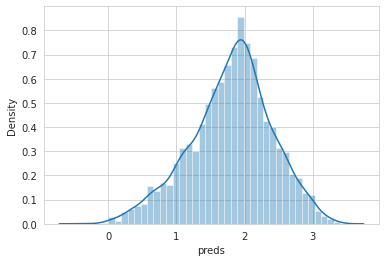

In [20]:
sns.distplot(Jbl.load(f"{OutputPath.model}/oof_df_{model_config.basic.run_name}.jbl")["preds"])
plt.show()

In [23]:
test = load_csv(input_path.test)
test = test.assign(object_path = test["object_id"].apply(lambda x: to_img_path(input_path.photos_prefix, x)))
InferenceRunner(model_config).run_cv(test)

fold: 0
Pretrained weights found at ../output/model/dino/exp11/checkpoint0280.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
fold: 1
Pretrained weights found at ../output/model/dino/exp11/checkpoint0280.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
fold: 2
Pretrained weights found at ../output/model/dino/exp11/checkpoint0280.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
fold